#### 8 (pdf до 20 Мб)
#### DF:
Январь 2022 года:   <br>cutlery — количество столовых приборов <br>
                    date — дата и время покупки <br>
                    order_price — сумма заказа <br>
                    uid — уникальный id пользователя <br>
                    tips — сумма чаевых<br>
                    order_id — уникальный номер заказа<br>
#### hyp:
uids WITH cutlery >2 HAVE tips > THEN OTHERS uids
#### agr:
COUNT uids WITH (cutlery >2 & date NOT IN range(01.01.2022, 09.01.2022) & order_price > 800)

In [43]:
import pandas as pd
import numpy as np

from statsmodels.stats.weightstats import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Посмотрим на данные

In [44]:
tips = pd.read_csv('shmya_final_version.csv')
tips.date = tips.date.astype('datetime64')
tips.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26057 entries, 0 to 26056
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         26057 non-null  datetime64[ns]
 1   cutlery      26057 non-null  int64         
 2   tips         26057 non-null  int64         
 3   order_price  26057 non-null  int64         
 4   uid          26057 non-null  int64         
 5   order_id     26057 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.2 MB


In [45]:
tips.head()

,date,cutlery,tips,order_price,uid,order_id
0,2022-01-17 06:38:43,3,100,1001,120967,73041443
1,2022-01-23 11:09:22,4,110,309,325757,60500835
2,2022-01-24 19:40:03,1,10,891,986730,43230531
3,2022-01-14 18:01:22,5,70,749,868648,46180789
4,2022-01-19 22:32:43,2,10,469,863523,59266169


#### Сначала попробуем второе задание (выборка сегмента коммуникации) - в нем, похоже, нет подвоха

In [46]:
special_uids = tips[(tips.cutlery > 2) & (tips.date > datetime.datetime(2022, 1, 10)) & (tips.order_price > 800)].uid.unique()
special_uids

array([120967, 255228, 781632, ..., 207178, 739019, 908699])

In [47]:
print('Все uid пользователей, которые добавляли в заказ больше двух комплектов столовых приборов и делали заказ не в январские праздники на сумму больше 800p - в переменной special_uids. Количество таких пользователей -',
      special_uids.shape[0])

Все uid пользователей, которые добавляли в заказ больше двух комплектов столовых приборов и делали заказ не в январские праздники на сумму больше 800p - в переменной special_uids. Количество таких пользователей - 2541


#### Теперь проверка гипотезы

In [48]:
mean_more2 = tips[tips.cutlery > 2].tips.mean()
mean_less3 = tips[tips.cutlery <= 2].tips.mean()
print('средние чаевые в заказах с >2 приборов -', round(mean_more2, 2), 
      '; средние чаевые в заказах с <=2 приборов -', round(mean_less3, 2))

средние чаевые в заказах с >2 приборов - 66.19 ; средние чаевые в заказах с <=2 приборов - 51.56


Это характеристики заказов (на самом деле нет, но об этом ниже), наша же гипотеза - "пользователи, которые выбирают больше двух комплектов приборов, оставляют больше чаевых, чем остальные" 
<br><br>Как можно интерпретировать эту формулировку:
<br>пользователи, которые всегда берут >2 приборов (ВСЕГДА-пользователи)
<br>или
<br>пользователи, которые хоть раз брали >2 приборов (ИНОГДА-пользователи)

In [49]:
print('всего уникальных пользователей -', tips.uid.unique().shape[0])

всего уникальных пользователей - 6433


In [50]:
# ИНОГДА пользователей
a = tips[tips.cutlery > 2].uid.unique()
# !ИНОГДА
b = np.setdiff1d(tips.uid.unique(), a)
print('пользователи, которые хоть раз брали >2 приборов -', a.shape[0], 
      ', остальные -', b.shape[0])

пользователи, которые хоть раз брали >2 приборов - 5719 , остальные - 714


#### тут хочется остановится на датах - январские праздники - это интересно, но для проверки гипотезы это может быть "выбросом" - сгруппируем по датам, чтобы сравнить данные на каникулах и в остальные дни

In [51]:
tips_shortdate = tips.copy()#[['date', 'cutlery', 'tips', 'order_price']].copy()
tips_shortdate.date = tips_shortdate.date.astype('datetime64[D]')
tips_shortdate_sums = tips_shortdate[['date', 'cutlery', 'tips', 'order_price']].groupby(tips_shortdate.date).sum()
tips_shortdate_uniq = tips_shortdate[['uid', 'order_id']].groupby(tips_shortdate.date).nunique()
tips_shortdate_check = tips_shortdate[['uid', 'order_id']].groupby(tips_shortdate.date).count()
tips_shortdate = tips_shortdate_sums.merge(tips_shortdate_uniq, on='date').merge(tips_shortdate_check, on='date')
tips_shortdate = tips_shortdate.reset_index()
tips_shortdate

,date,cutlery,tips,order_price,uid_x,order_id_x,uid_y,order_id_y
0,2022-01-01,15992,54390,511788,3043,3048,3506,3506
1,2022-01-02,2269,53000,526855,734,734,773,773
2,2022-01-03,2300,51230,520637,752,753,785,785
3,2022-01-04,2222,50870,517028,708,708,751,751
4,2022-01-05,2245,52700,516428,730,730,772,772
5,2022-01-06,2227,51100,497916,701,701,733,733
6,2022-01-07,2307,51470,514500,723,723,770,770
7,2022-01-08,2215,51410,496476,711,711,746,746
8,2022-01-09,2212,50700,499900,699,700,745,745
9,2022-01-10,2128,49800,478029,663,663,707,707


#### похоже уникальные id заказов не такие уж и уникальные=) 

In [52]:
ids = tips.order_id
tips[ids.isin(ids[ids.duplicated()])].sort_values('order_id')

,date,cutlery,tips,order_price,uid,order_id
2825,2022-01-02 20:12:28,4,10,829,999572,10004061
20497,2022-01-12 07:04:02,3,40,805,999572,10004061
16585,2022-01-30 02:09:05,5,90,503,999572,10004061
22131,2022-01-15 00:58:02,4,30,687,691367,10013767
9408,2022-01-08 05:24:57,1,50,705,691367,10013767
...,...,...,...,...,...,...
11665,2022-01-26 14:00:56,2,30,524,755602,99939588
7320,2022-01-01 16:48:58,4,0,0,755602,99939588
17730,2022-01-01 20:37:52,3,60,446,755602,99939588
2586,2022-01-17 10:38:23,1,40,780,690072,99976909


#### id заказов образуют пары с id пользователей

посмотрим на распределение данных по датам

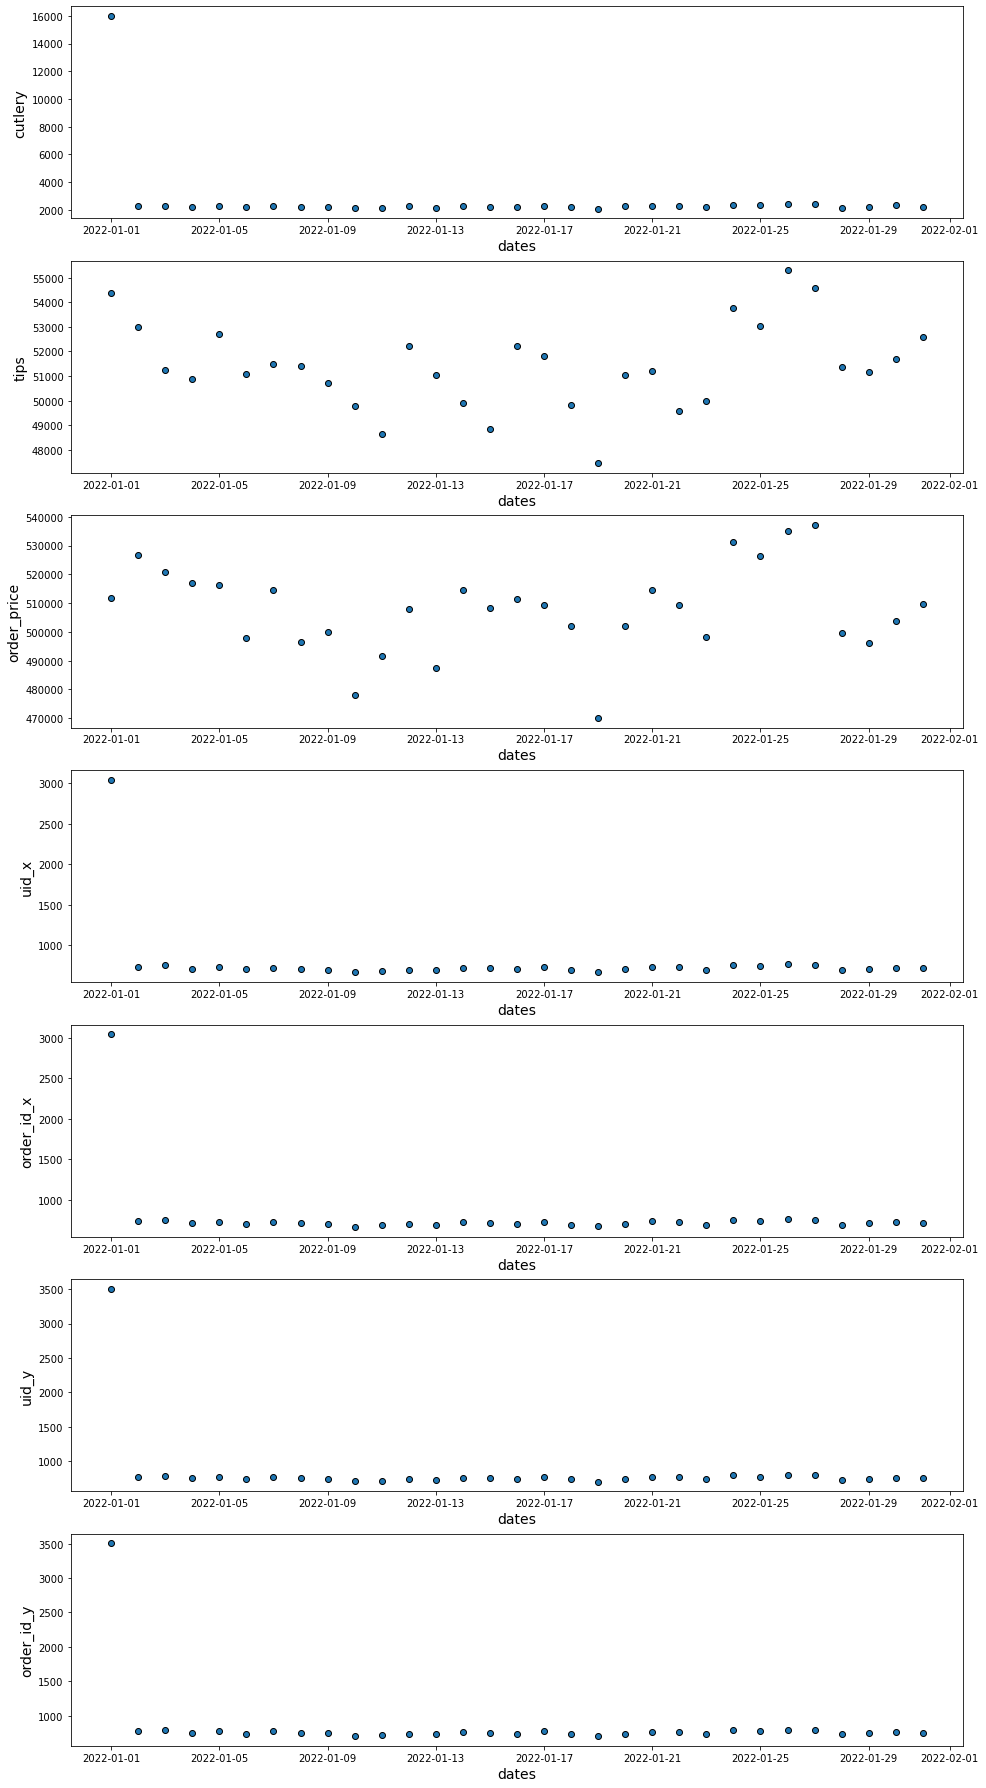

In [53]:
pyplot.figure(figsize(16, 32))
for i in range (1, 8):
    pyplot.subplot(7, 1, i)
    pyplot.scatter(tips_shortdate['date'], tips_shortdate.iloc[:, i], edgecolors="black")
    pyplot.xlabel('dates', fontsize=14)
    pyplot.ylabel(str(tips_shortdate.columns[i]), fontsize=14)

#### да, 01.01 ситуация нетиповая
наверное, это можно интерпритировать как "у нас с НГ остались салаты и гости, давайте закажем что-нибудь легкое и побольше приборов на всех", при этом сумма заказов осталась на среднем уровне, идем дальше


In [54]:
tips_from2 = tips[tips.date >= datetime.datetime(2022, 1, 2)]#.sort_values('date')
tips_from2

,date,cutlery,tips,order_price,uid,order_id
0,2022-01-17 06:38:43,3,100,1001,120967,73041443
1,2022-01-23 11:09:22,4,110,309,325757,60500835
2,2022-01-24 19:40:03,1,10,891,986730,43230531
3,2022-01-14 18:01:22,5,70,749,868648,46180789
4,2022-01-19 22:32:43,2,10,469,863523,59266169
...,...,...,...,...,...,...
26052,2022-01-04 05:21:39,4,10,763,182587,85041983
26053,2022-01-18 14:43:12,3,60,790,187031,47894568
26054,2022-01-26 18:08:02,1,90,502,247419,75350869
26055,2022-01-18 05:55:09,2,80,418,474601,79438423


исследуя струткру данных также находим вот такой шаблон: 

In [55]:
tips[tips.order_price == 0]

,date,cutlery,tips,order_price,uid,order_id
6,2022-01-01 08:52:23,4,0,0,779134,15841612
7,2022-01-01 06:21:14,6,0,0,751242,83957554
26,2022-01-01 19:51:35,4,0,0,307676,43056019
49,2022-01-01 21:58:31,5,0,0,741562,51847053
54,2022-01-01 16:07:42,5,0,0,806167,49572522
...,...,...,...,...,...,...
26017,2022-01-01 10:44:21,4,0,0,107130,10564056
26035,2022-01-01 08:39:20,5,0,0,892785,78217751
26040,2022-01-01 02:29:59,4,0,0,776175,23958667
26042,2022-01-01 02:51:01,5,0,0,904144,17789596


In [56]:
tips[(tips.order_price == 0) & (tips.tips != 0)]

,date,cutlery,tips,order_price,uid,order_id


In [57]:
tips[tips.order_price == 0].cutlery.mean()

4.974945533769064

In [58]:
tips_from2[tips_from2.order_price == 0]

,date,cutlery,tips,order_price,uid,order_id


заказы с нулевой стоимостью (порядка 3000 записей) приходятся именно на 01.01, похоже, 01 января у Яндекс.Еды была акция по бесплатной доставке приборов - среднее их количество в "нулевых" заказах немного не дотягивает до 5

сколько пользователей в выборке без 1 января

In [59]:
print('всего уникальных пользователей -', tips_from2.uid.unique().shape[0])

всего уникальных пользователей - 6413


#### начнем с ИНОГДА гипотезы

In [60]:
# ИНОГДА пользователей
a = tips_from2[tips_from2.cutlery > 2].uid.unique()
# НИКОГДА
b = np.setdiff1d(tips_from2.uid.unique(), a)
print('пользователи, которые хоть раз брали >2 приборов -', a.shape[0], 
      ', остальные -', b.shape[0])

пользователи, которые хоть раз брали >2 приборов - 5636 , остальные - 777


In [61]:
tips_more2 = tips_from2[tips_from2.uid.isin(a)]
tips_less3 = tips_from2[tips_from2.uid.isin(b)]
print('средние чаевые в заказах пользователей, которые иногда >2 приборов -', round(tips_more2.tips.mean(), 2)) 
print('средние чаевые в заказах пользователей, которые никогда >2 приборов -', round(tips_less3.tips.mean(), 2))

средние чаевые в заказах пользователей, которые иногда >2 приборов - 70.16
средние чаевые в заказах пользователей, которые никогда >2 приборов - 40.41


оценим нормальность распределений

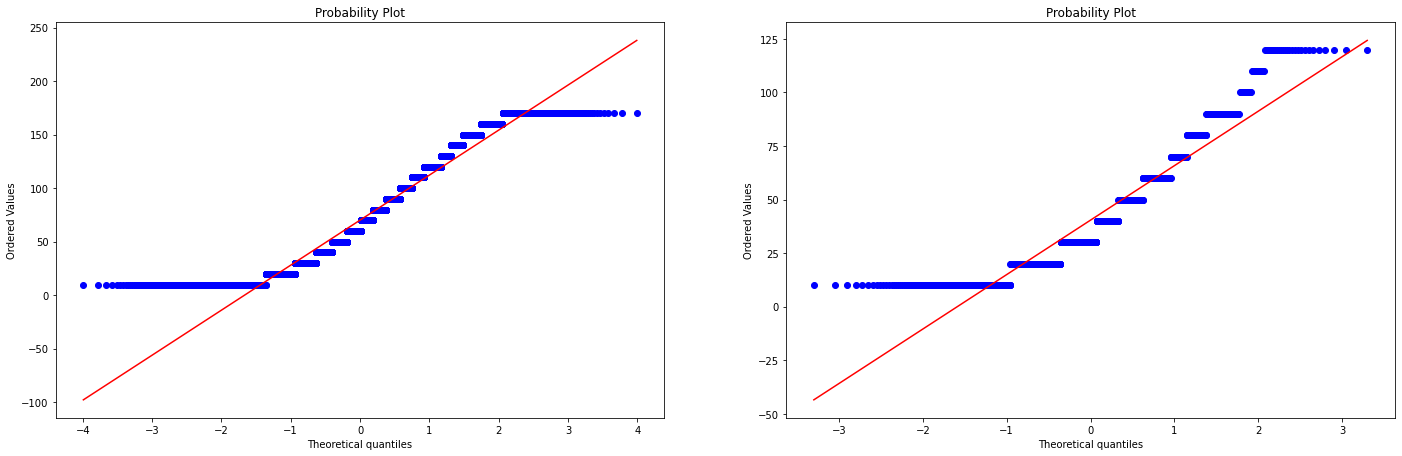

In [62]:
pylab.figure(figsize=(24,16))
pylab.subplot(2,2,1)
stats.probplot(tips_more2.tips, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(tips_less3.tips, dist="norm", plot=pylab)
pylab.show()

In [63]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(tips_more2.tips))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(tips_less3.tips))

Shapiro-Wilk normality test, W-statistic: 0.948092, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.897732, p-value: 0.000000


похоже все вполне нормально=) используем двухвыборочный критерий Стьюдента для независимых выборок

In [64]:
stats.ttest_ind(tips_more2.tips, tips_less3.tips, equal_var = False)

Ttest_indResult(statistic=38.813560183154856, pvalue=1.3978370473346441e-245)

#### считаю ИНОГДА гипотезу подтвержденной

In [65]:
# ВСЕГДА пользователей
a = tips_from2[tips_from2.cutlery > 2].uid.unique()
c = tips_from2[tips_from2.cutlery <=3].uid.unique()
a = np.setdiff1d(a, c)
# НЕВСЕГДА
b = np.setdiff1d(tips_from2.uid.unique(), a)
print('пользователи, которые всегда брали >2 приборов -', a.shape[0], 
      ', остальные -', b.shape[0])

пользователи, которые всегда брали >2 приборов - 292 , остальные - 6121


In [66]:
tips_more2 = tips_from2[tips_from2.uid.isin(a)]
tips_less3 = tips_from2[tips_from2.uid.isin(b)]
print('средние чаевые в заказах пользователей, которые всегда >2 приборов -', round(tips_more2.tips.mean(), 2)) 
print('средние чаевые в заказах пользователей, которые невсегда >2 приборов -', round(tips_less3.tips.mean(), 2))

средние чаевые в заказах пользователей, которые всегда >2 приборов - 42.66
средние чаевые в заказах пользователей, которые невсегда >2 приборов - 68.86


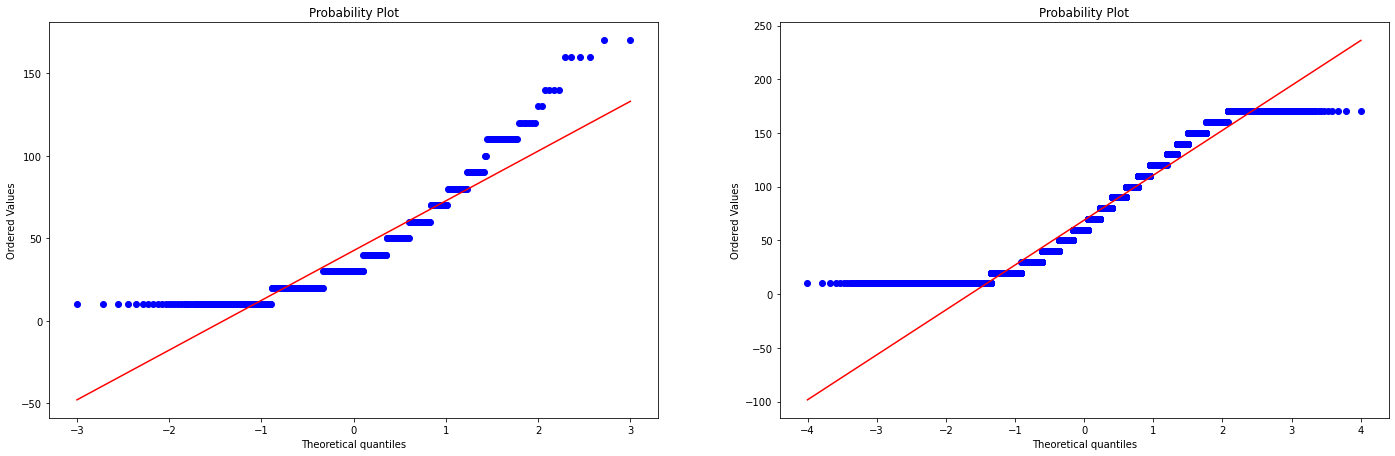

In [67]:
pylab.figure(figsize=(24,16))
pylab.subplot(2,2,1)
stats.probplot(tips_more2.tips, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(tips_less3.tips, dist="norm", plot=pylab)
pylab.show()

In [68]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(tips_more2.tips))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(tips_less3.tips))

Shapiro-Wilk normality test, W-statistic: 0.854265, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.945240, p-value: 0.000000


In [69]:
stats.ttest_ind(tips_more2.tips, tips_less3.tips, equal_var = False)

Ttest_indResult(statistic=-17.89522683980752, pvalue=7.57279791976877e-57)

#### считаю ВСЕГДА гипотезу опровергнутой

#### посомтрим на данные чуть подробнее

Text(0.5, 0, 'cutlery')

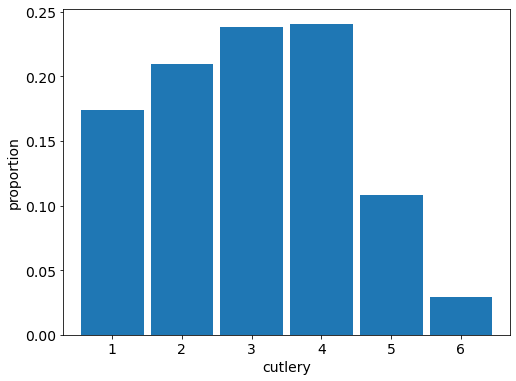

In [70]:
plt.figure(figsize(8,6))
stat = tips_from2.groupby('cutlery')['cutlery'].agg(lambda x : float(len(x))/tips_from2.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9)
plt.xticks(rotation=0)
plt.ylabel('proportion', fontsize=14)
plt.xlabel('cutlery', fontsize=14)

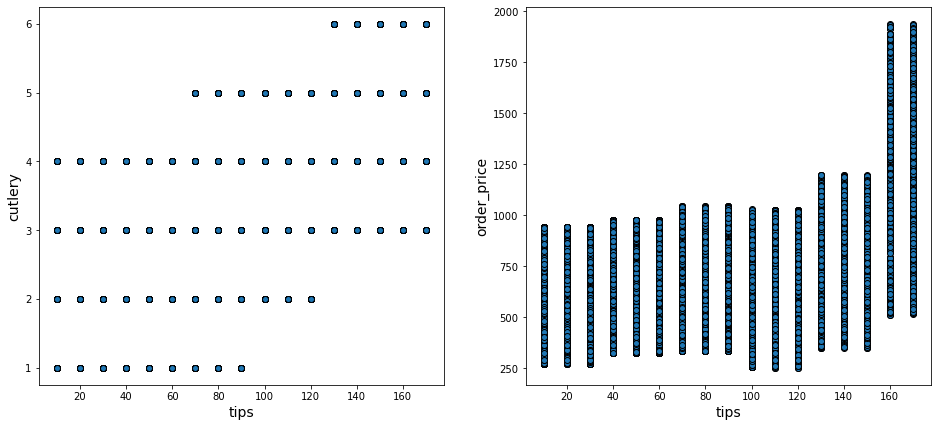

In [71]:
pyplot.figure(figsize(16, 32))
for i in range (1, 3):
    pyplot.subplot(4, 2, i)
    pyplot.scatter(tips_from2['tips'], tips_from2[['date', 'cutlery', 'order_price']].iloc[:, i], edgecolors="black")
    pyplot.xlabel('tips', fontsize=14)
    pyplot.ylabel(str(tips_from2[['date','cutlery', 'order_price']].columns[i]), fontsize=14)

#### похоже, чаевые зависят и от колчества приборов, и от суммы заказа

Попробуем оценить размер чаевых по параметрам заказа. Изначально возьмем только для параметра (количество приборов и сумма заказа), в дальнейшем можно будет добавить сегмент пользователя, время суток, день недели и т.п., но к жэтому времени аналитики, наверное, уже вернутся. Пока посмотрим на то, что мы будем прогнозировать:

In [72]:
tips_from2.tips.unique()

array([100, 110,  10,  70,  90,  50,  60, 150,  80, 140,  30, 170,  40,
        20, 120, 130, 160])

Text(0.5, 0, 'tips')

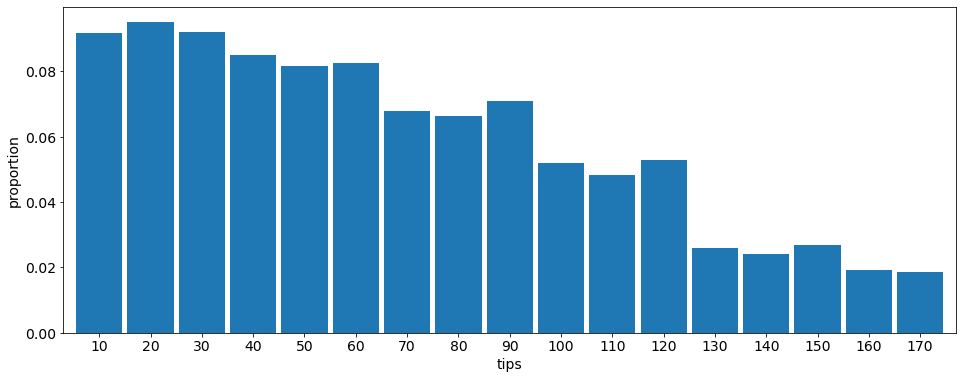

In [73]:
plt.figure(figsize(16,6))
stat = tips_from2.groupby('tips')['tips'].agg(lambda x : float(len(x))/tips_from2.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9)
plt.xticks(rotation=0)
plt.ylabel('proportion', fontsize=14)
plt.xlabel('tips', fontsize=14)

задача где-то между регрессией и многоклассовой классификацией - посмотрим, что с регрессией, разобьем выборку на трейн и тест

In [74]:
X_train, X_test, y_train, y_test = train_test_split(tips_from2[['cutlery', 'order_price']], 
                                                    tips_from2.tips, 
                                                    test_size=0.25, 
                                                    stratify=tips_from2.tips)

Что будет если прогнозировать средним:

In [75]:
print('среднеквадратичная на трейне', sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train)))
print('среднеквадратичная на тесте',sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test)))

среднеквадратичная на трейне 42.952621832663105
среднеквадратичная на тесте 42.93716888659511


Попробуем для начала линейную регрессию

In [76]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [77]:
print('среднеквадратичная на трейне', sqrt(mean_squared_error(lm.predict(X_train), y_train)))
print('среднеквадратичная на тесте', sqrt(mean_squared_error(lm.predict(X_test), y_test)))
print('коэффициент детерминации',lm.score(X_test, y_test))

среднеквадратичная на трейне 36.78753733172759
среднеквадратичная на тесте 36.81017045969099
коэффициент детерминации 0.26503067384113


А теперь случайный лес

In [78]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3)

In [79]:
print('среднеквадратичная на трейне', sqrt(mean_squared_error(rf.predict(X_train), y_train)))
print('среднеквадратичная на тесте', sqrt(mean_squared_error(rf.predict(X_test), y_test)))
print('коэффициент детерминации', rf.score(X_test, y_test))

среднеквадратичная на трейне 30.353673127811383
среднеквадратичная на тесте 35.61808114560638
коэффициент детерминации 0.3118634986300507


неидеально, но начало положено=) 
<br> Что с предсказательной способностью:

In [80]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
1,order_price,0.537838
0,cutlery,0.462162


### похоже сумма заказа чуть больше влияет на разммер чаевых чем количество приборов